In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
from plotly.subplots import make_subplots

In [2]:
sqlite_connection = sqlite3.connect('sample.sqlite')
print("Database created and Successfully Connected to SQLite")

Database created and Successfully Connected to SQLite


In [3]:
query_1 = '''select *
               from account
          '''
account_full = pd.read_sql_query(query_1, sqlite_connection)

In [4]:
account_full.describe(include='all')

account_id             created_time created_device created_platform  \
count      112792                   112792         112792           112792   
unique     112792                   112792          11327                2   
top      13514010  2016-03-02 17:11:00.332      iPhone7,2          Android   
freq            1                        1           2764            92253   
mean          NaN                      NaN            NaN              NaN   
std           NaN                      NaN            NaN              NaN   
min           NaN                      NaN            NaN              NaN   
25%           NaN                      NaN            NaN              NaN   
50%           NaN                      NaN            NaN              NaN   
75%           NaN                      NaN            NaN              NaN   
max           NaN                      NaN            NaN              NaN   

       country_code  created_app_store_id  
count        112685         112792.000000  
unique          189                   NaN  
top              CN                   NaN  
freq          38044                   NaN  
mean            NaN              3.622358  
std             NaN              4.223163  
min             NaN              0.000000  
25%             NaN              2.000000  
50%             NaN              2.000000  
75%             NaN              3.000000  
max             NaN             19.000000

In [6]:
query_2 = '''select *
               from account_date_session
          '''
account_date_session_full = pd.read_sql_query(query_2, sqlite_connection)

In [7]:
account_date_session_full.describe(include='all')

account_id        date  session_count  session_duration_sec
count       1698974     1698974   1.698974e+06          1.698974e+06
unique       112451         366            NaN                   NaN
top     34371645828  2016-05-21            NaN                   NaN
freq            366        5476            NaN                   NaN
mean            NaN         NaN   3.587891e+00          1.434244e+03
std             NaN         NaN   3.671223e+00          1.715709e+03
min             NaN         NaN   1.000000e+00          1.000000e+00
25%             NaN         NaN   1.000000e+00          3.490000e+02
50%             NaN         NaN   2.000000e+00          8.660000e+02
75%             NaN         NaN   5.000000e+00          1.867000e+03
max             NaN         NaN   2.630000e+02          5.705000e+04

In [9]:
query_3 = '''select *
               from iap_purchase
          '''
iap_purchase_full = pd.read_sql_query(query_3, sqlite_connection)

In [10]:
iap_purchase_full.describe(include='all')

account_id             created_time                   package_id_hash  \
count         9909                     9909                              9909   
unique        1549                     9909                                10   
top     4309071360  2016-03-26 23:59:59.355  99a9e0e63efa2fdce8fc8de74c66cea9   
freq           119                        1                              3058   
mean           NaN                      NaN                               NaN   
std            NaN                      NaN                               NaN   
min            NaN                      NaN                               NaN   
25%            NaN                      NaN                               NaN   
50%            NaN                      NaN                               NaN   
75%            NaN                      NaN                               NaN   
max            NaN                      NaN                               NaN   

        iap_price_usd_cents  app_store_id  
count           9909.000000   9909.000000  
unique                  NaN           NaN  
top                     NaN           NaN  
freq                    NaN           NaN  
mean             429.090927      2.689777  
std              681.551349      4.773476  
min               36.000000      0.000000  
25%               36.000000      0.000000  
50%              184.000000      1.000000  
75%              369.000000      2.000000  
max             3699.000000     19.000000

**Are there any trends visible in the revenue or the daily active users?**

In [12]:
query_revenue = '''select date(created_time) as dates,
                          sum(iap_price_usd_cents)/100.0 as daily_revenue_usd
                     from iap_purchase
                    group by date(created_time)
          '''
daily_revenue = pd.read_sql_query(query_revenue, sqlite_connection)

In [ ]:
#daily_revenue

In [14]:
fig = px.line(daily_revenue, x="dates", y="daily_revenue_usd", title='Total revenue in USD daily')
fig.show()

In [ ]:
daily_revenue.loc[:, 'months'] = pd.to_datetime(daily_revenue.dates).dt.to_period('M')
monthly_revenue = daily_revenue.groupby(['months'])['daily_revenue_usd']\
                                .sum()\
                                .reset_index()\
                                .rename(columns={'daily_revenue_usd': 'revenue_usd'})
monthly_revenue.months = monthly_revenue.months.astype(str)
#monthly_revenue

In [16]:
fig = px.bar(monthly_revenue, x='months', y='revenue_usd', title='Total revenue in USD monthly')
fig.show()

In [ ]:
daily_revenue['dates'] = pd.to_datetime(daily_revenue['dates'])
daily_revenue = daily_revenue.set_index(['dates'])
#daily_revenue

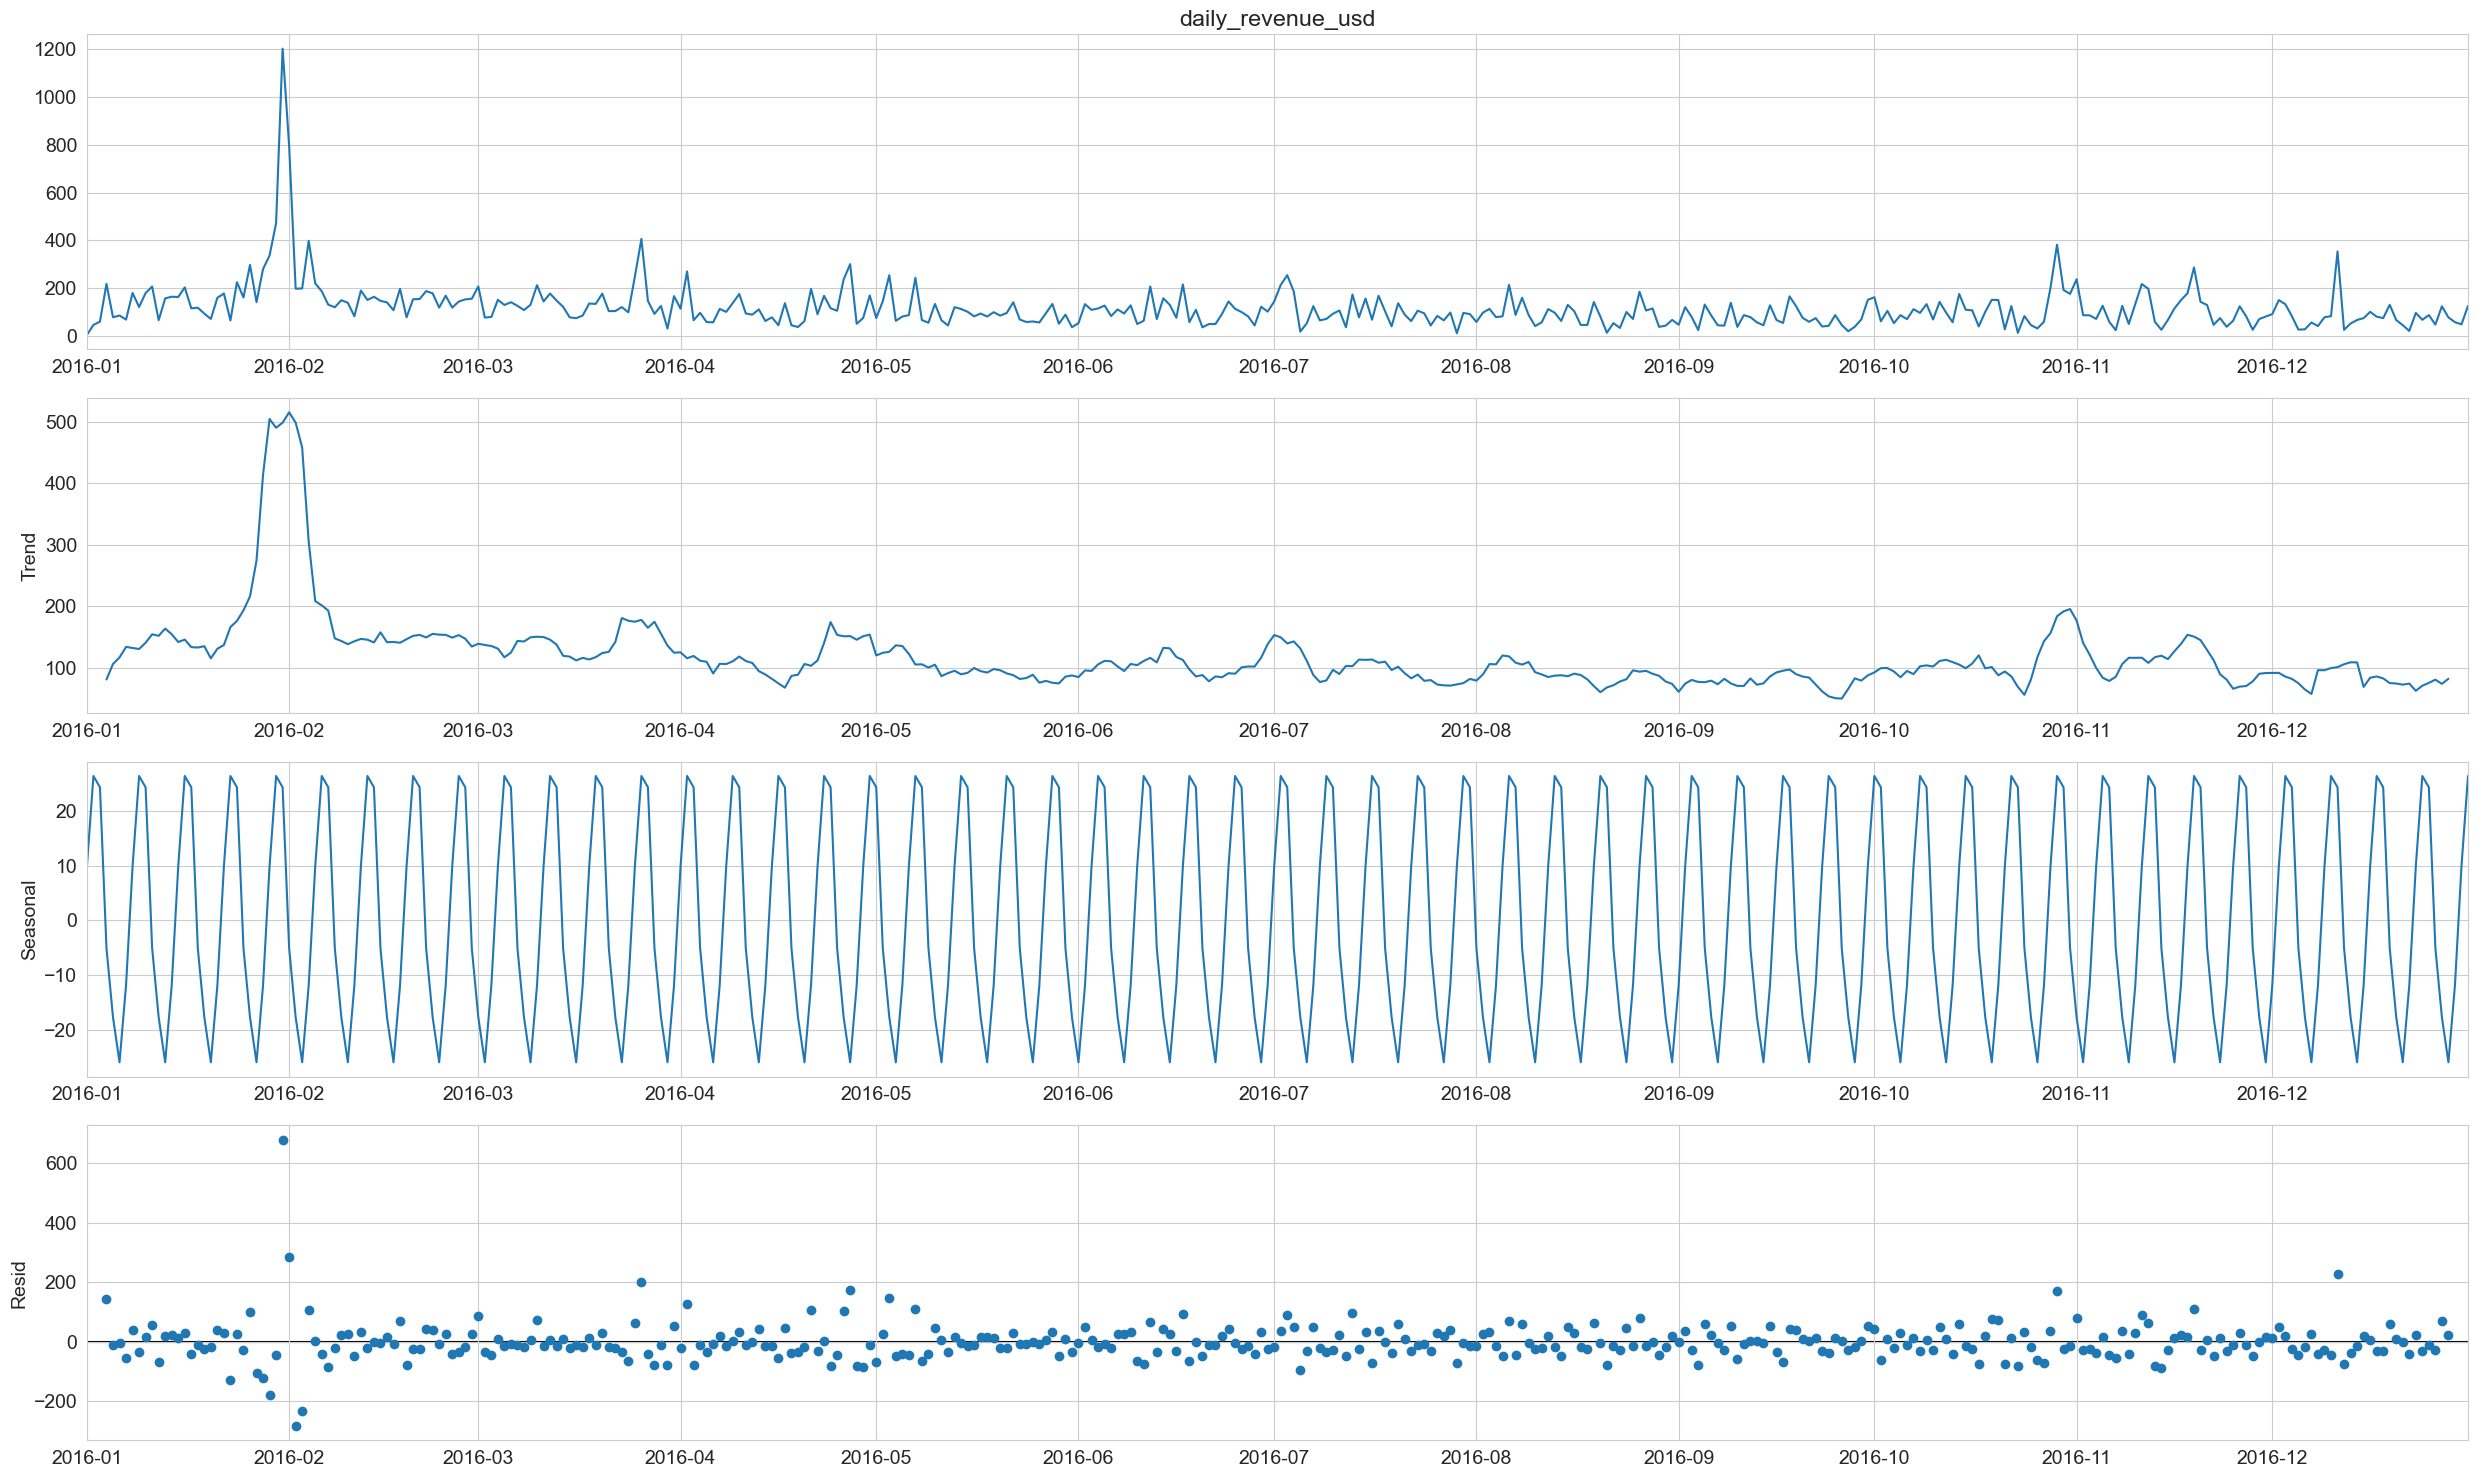

In [18]:
plt.rcParams['figure.figsize'] = 25, 15
plt.rc('font',size=14)
decomposition1 = sm.tsa.seasonal_decompose(daily_revenue['daily_revenue_usd'], model='additive')
fig = decomposition1.plot()
plt.show()

In [19]:
seasonality = decomposition1.seasonal.reset_index().iloc[3:10, :]
seasonality.loc[:, 'week_day'] = seasonality.dates.dt.day_name()
seasonality

dates   seasonal   week_day
3 2016-01-04  -5.073584     Monday
4 2016-01-05 -17.717897    Tuesday
5 2016-01-06 -25.964903  Wednesday
6 2016-01-07 -11.874804   Thursday
7 2016-01-08   9.872787     Friday
8 2016-01-09  26.413487   Saturday
9 2016-01-10  24.344916     Sunday

In [20]:
fig = px.bar(seasonality, x='week_day', y='seasonal', title='Seasonal trend of daily total revenue')
fig.show()

In [21]:
trend = decomposition1.trend.reset_index()
trend.dates = trend.dates.astype(str)

In [22]:
fig = px.line(trend, x="dates", y="trend", title='Decomposed trend of daily total revenue')
fig.show()

In [23]:
query_arpu = '''select ads.date,
                       count(ads.account_id) as n_active_users,
                       sum(ip.is_payer) as n_paying_users,
                       sum(payments_usd) as total_revenue_usd,
                       sum(payments_usd) / count(ads.account_id) as arpu,
                       sum(payments_usd) / sum(ip.is_payer) as arppu
                  from account_date_session ads
                  left join (select account_id,
                                    1 as is_payer,
                                    date(created_time) as dates,
                                    sum(iap_price_usd_cents)/100.0 as payments_usd
                               from iap_purchase
                              group by 1, 2, 3
                            ) ip
                    on ads.account_id = ip.account_id
                   and ads.date = ip.dates
                 group by ads.date

          '''
revenue_and_active_users = pd.read_sql_query(query_arpu, sqlite_connection)

In [ ]:
#revenue_and_active_users

In [25]:
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=['Number of active users daily',
                'Number of payers daily',
                'Average revenue per active user daily',
                'Average revenue per paying user daily'])
figures = [
    px.line(revenue_and_active_users, x="date", y="n_active_users"),
    px.line(revenue_and_active_users, x="date", y="n_paying_users"),
    px.line(revenue_and_active_users, x="date", y="arpu"),
    px.line(revenue_and_active_users, x="date", y="arppu")
]


for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=i+1, col=1)

fig.update_layout(height=1000)
fig.show()


In [ ]:
active_users = revenue_and_active_users[['date', 'n_active_users']]
active_users['date'] = pd.to_datetime(active_users['date'])
active_users = active_users.set_index(['date'])
#active_users

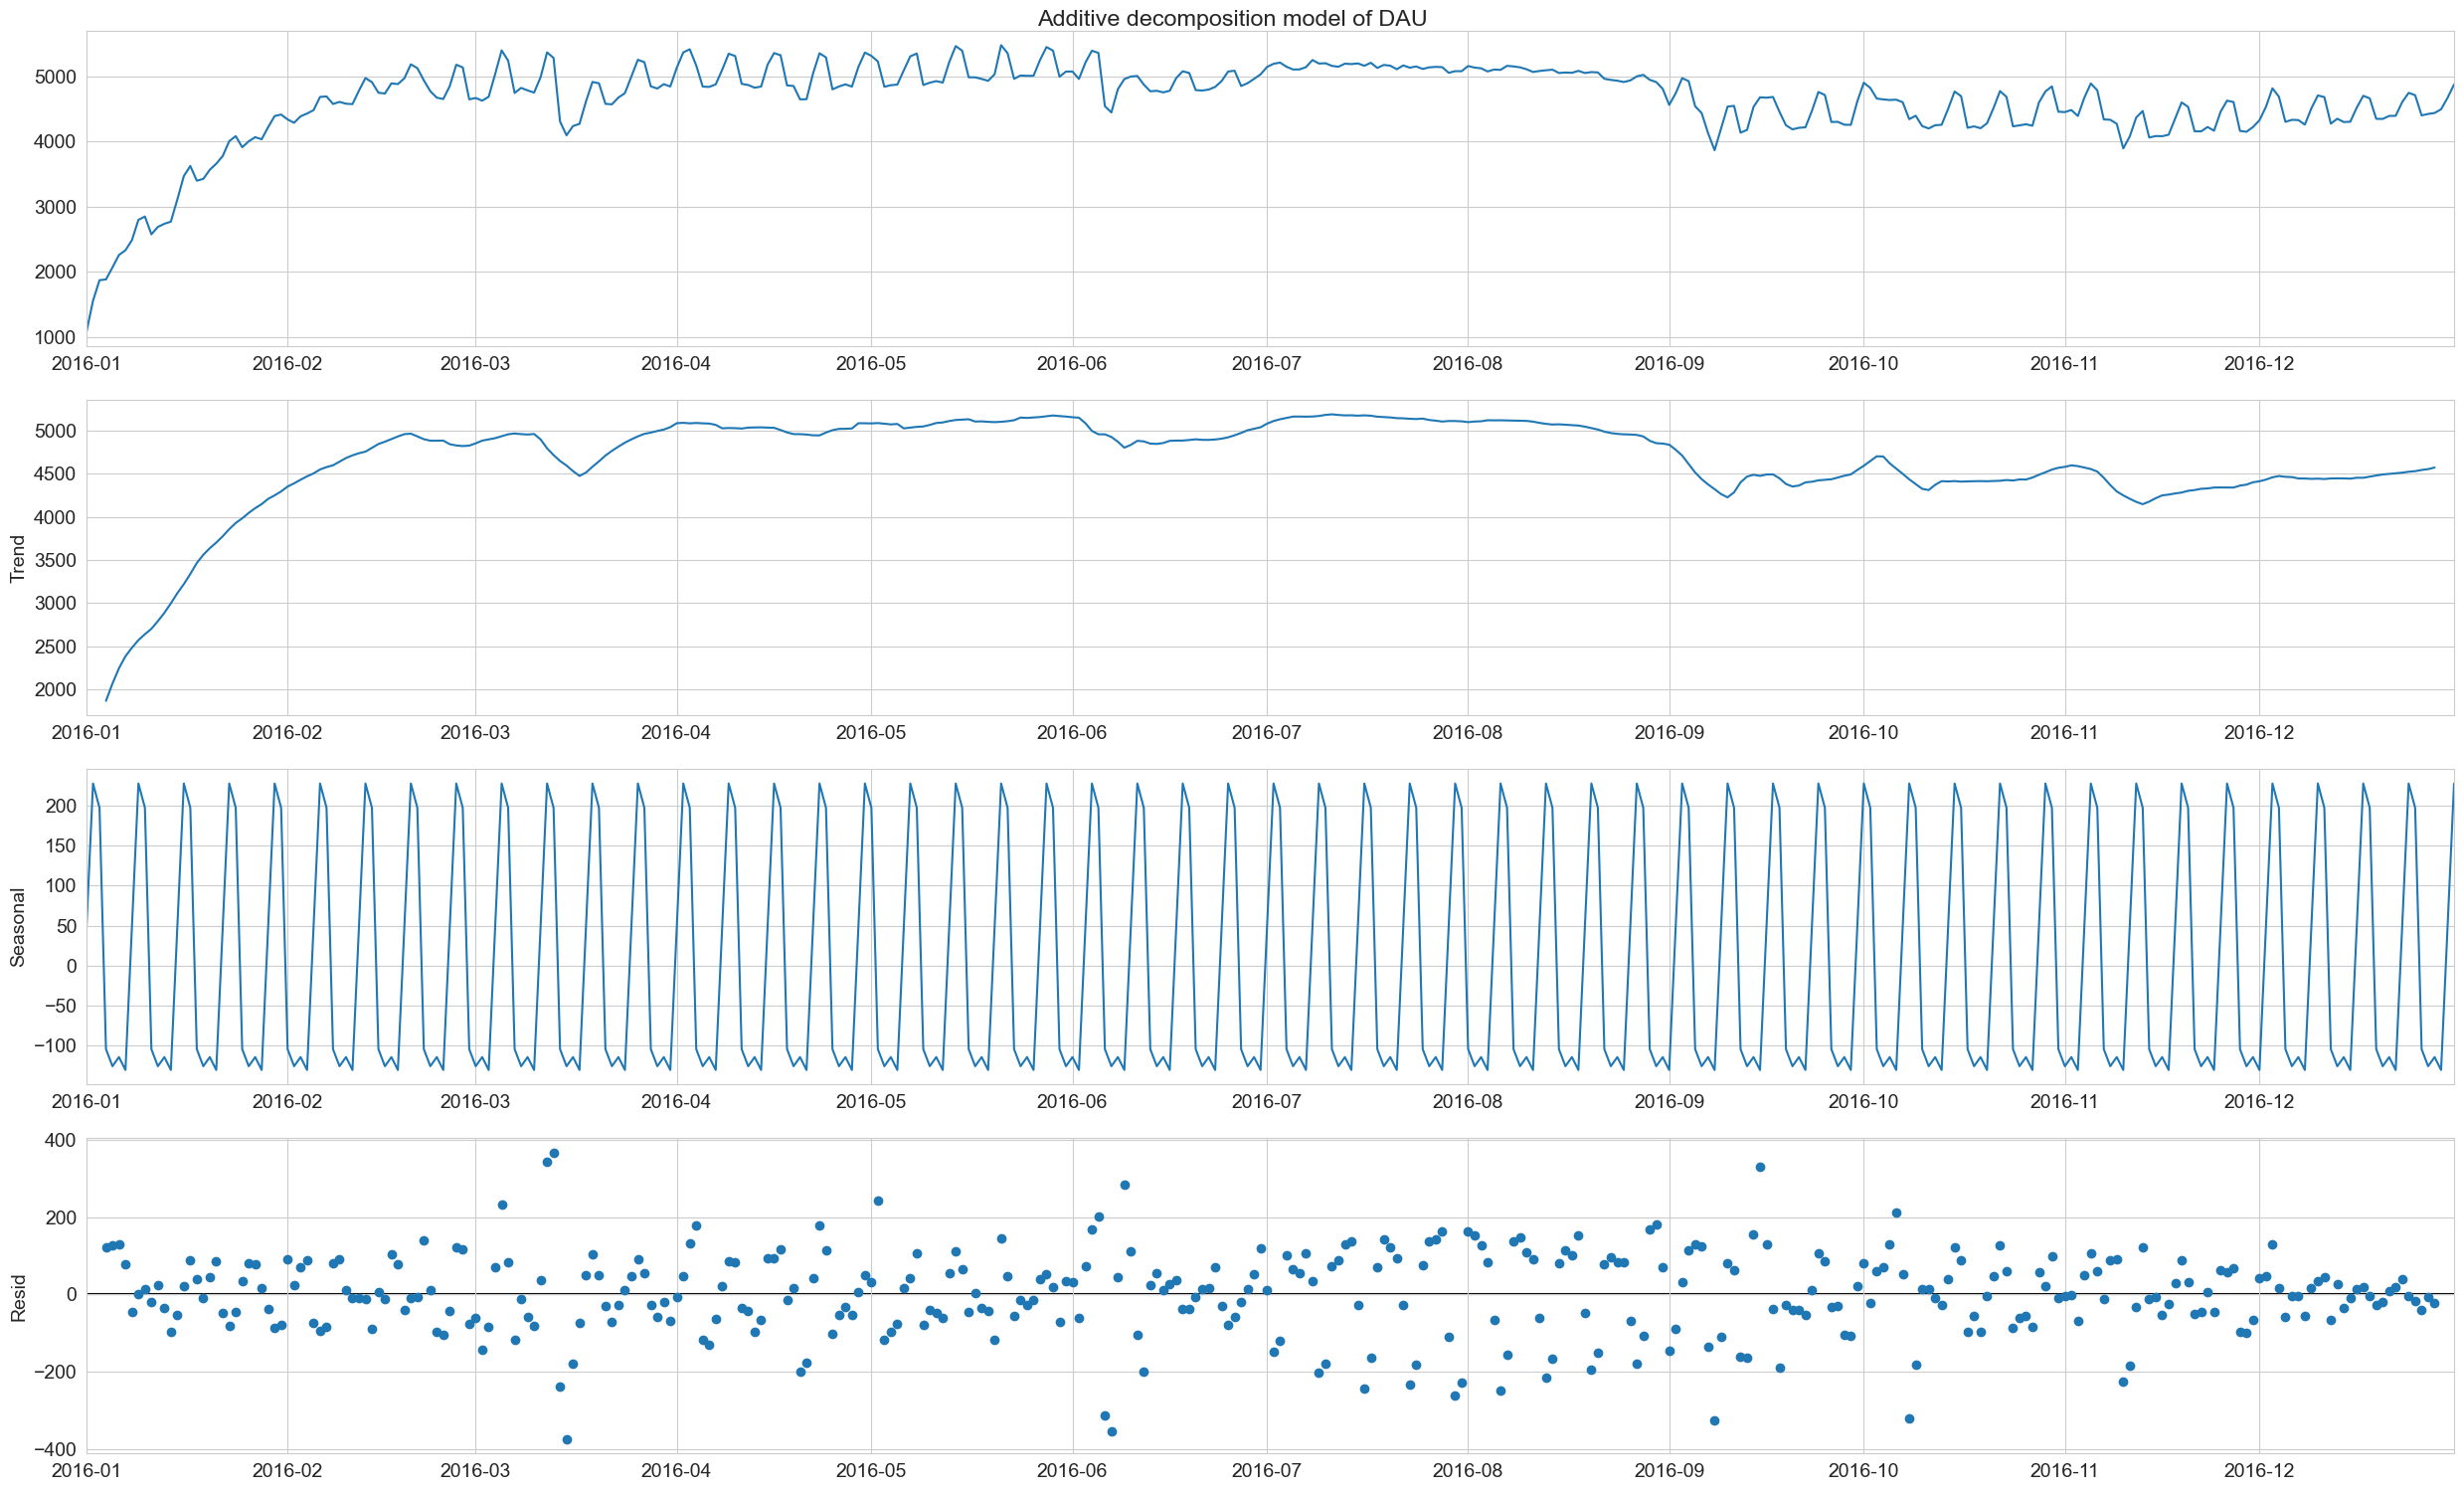

In [27]:
decomposition2 = sm.tsa.seasonal_decompose(active_users, model='additive')
fig = decomposition2.plot()
fig.suptitle('Additive decomposition model of DAU', x=0.5, y=1)
plt.show()

In [28]:
seasonality = decomposition2.seasonal.reset_index().iloc[3:10, :]
seasonality.loc[:, 'week_day'] = seasonality.date.dt.day_name()
seasonality

date    seasonal   week_day
3 2016-01-04 -104.378528     Monday
4 2016-01-05 -125.691715    Tuesday
5 2016-01-06 -114.298858  Wednesday
6 2016-01-07 -130.411926   Thursday
7 2016-01-08   49.935413     Friday
8 2016-01-09  227.579670   Saturday
9 2016-01-10  197.265945     Sunday

In [ ]:
payers = revenue_and_active_users[['date', 'n_paying_users']]
payers['date'] = pd.to_datetime(payers['date'])
payers = payers.set_index(['date'])
#payers

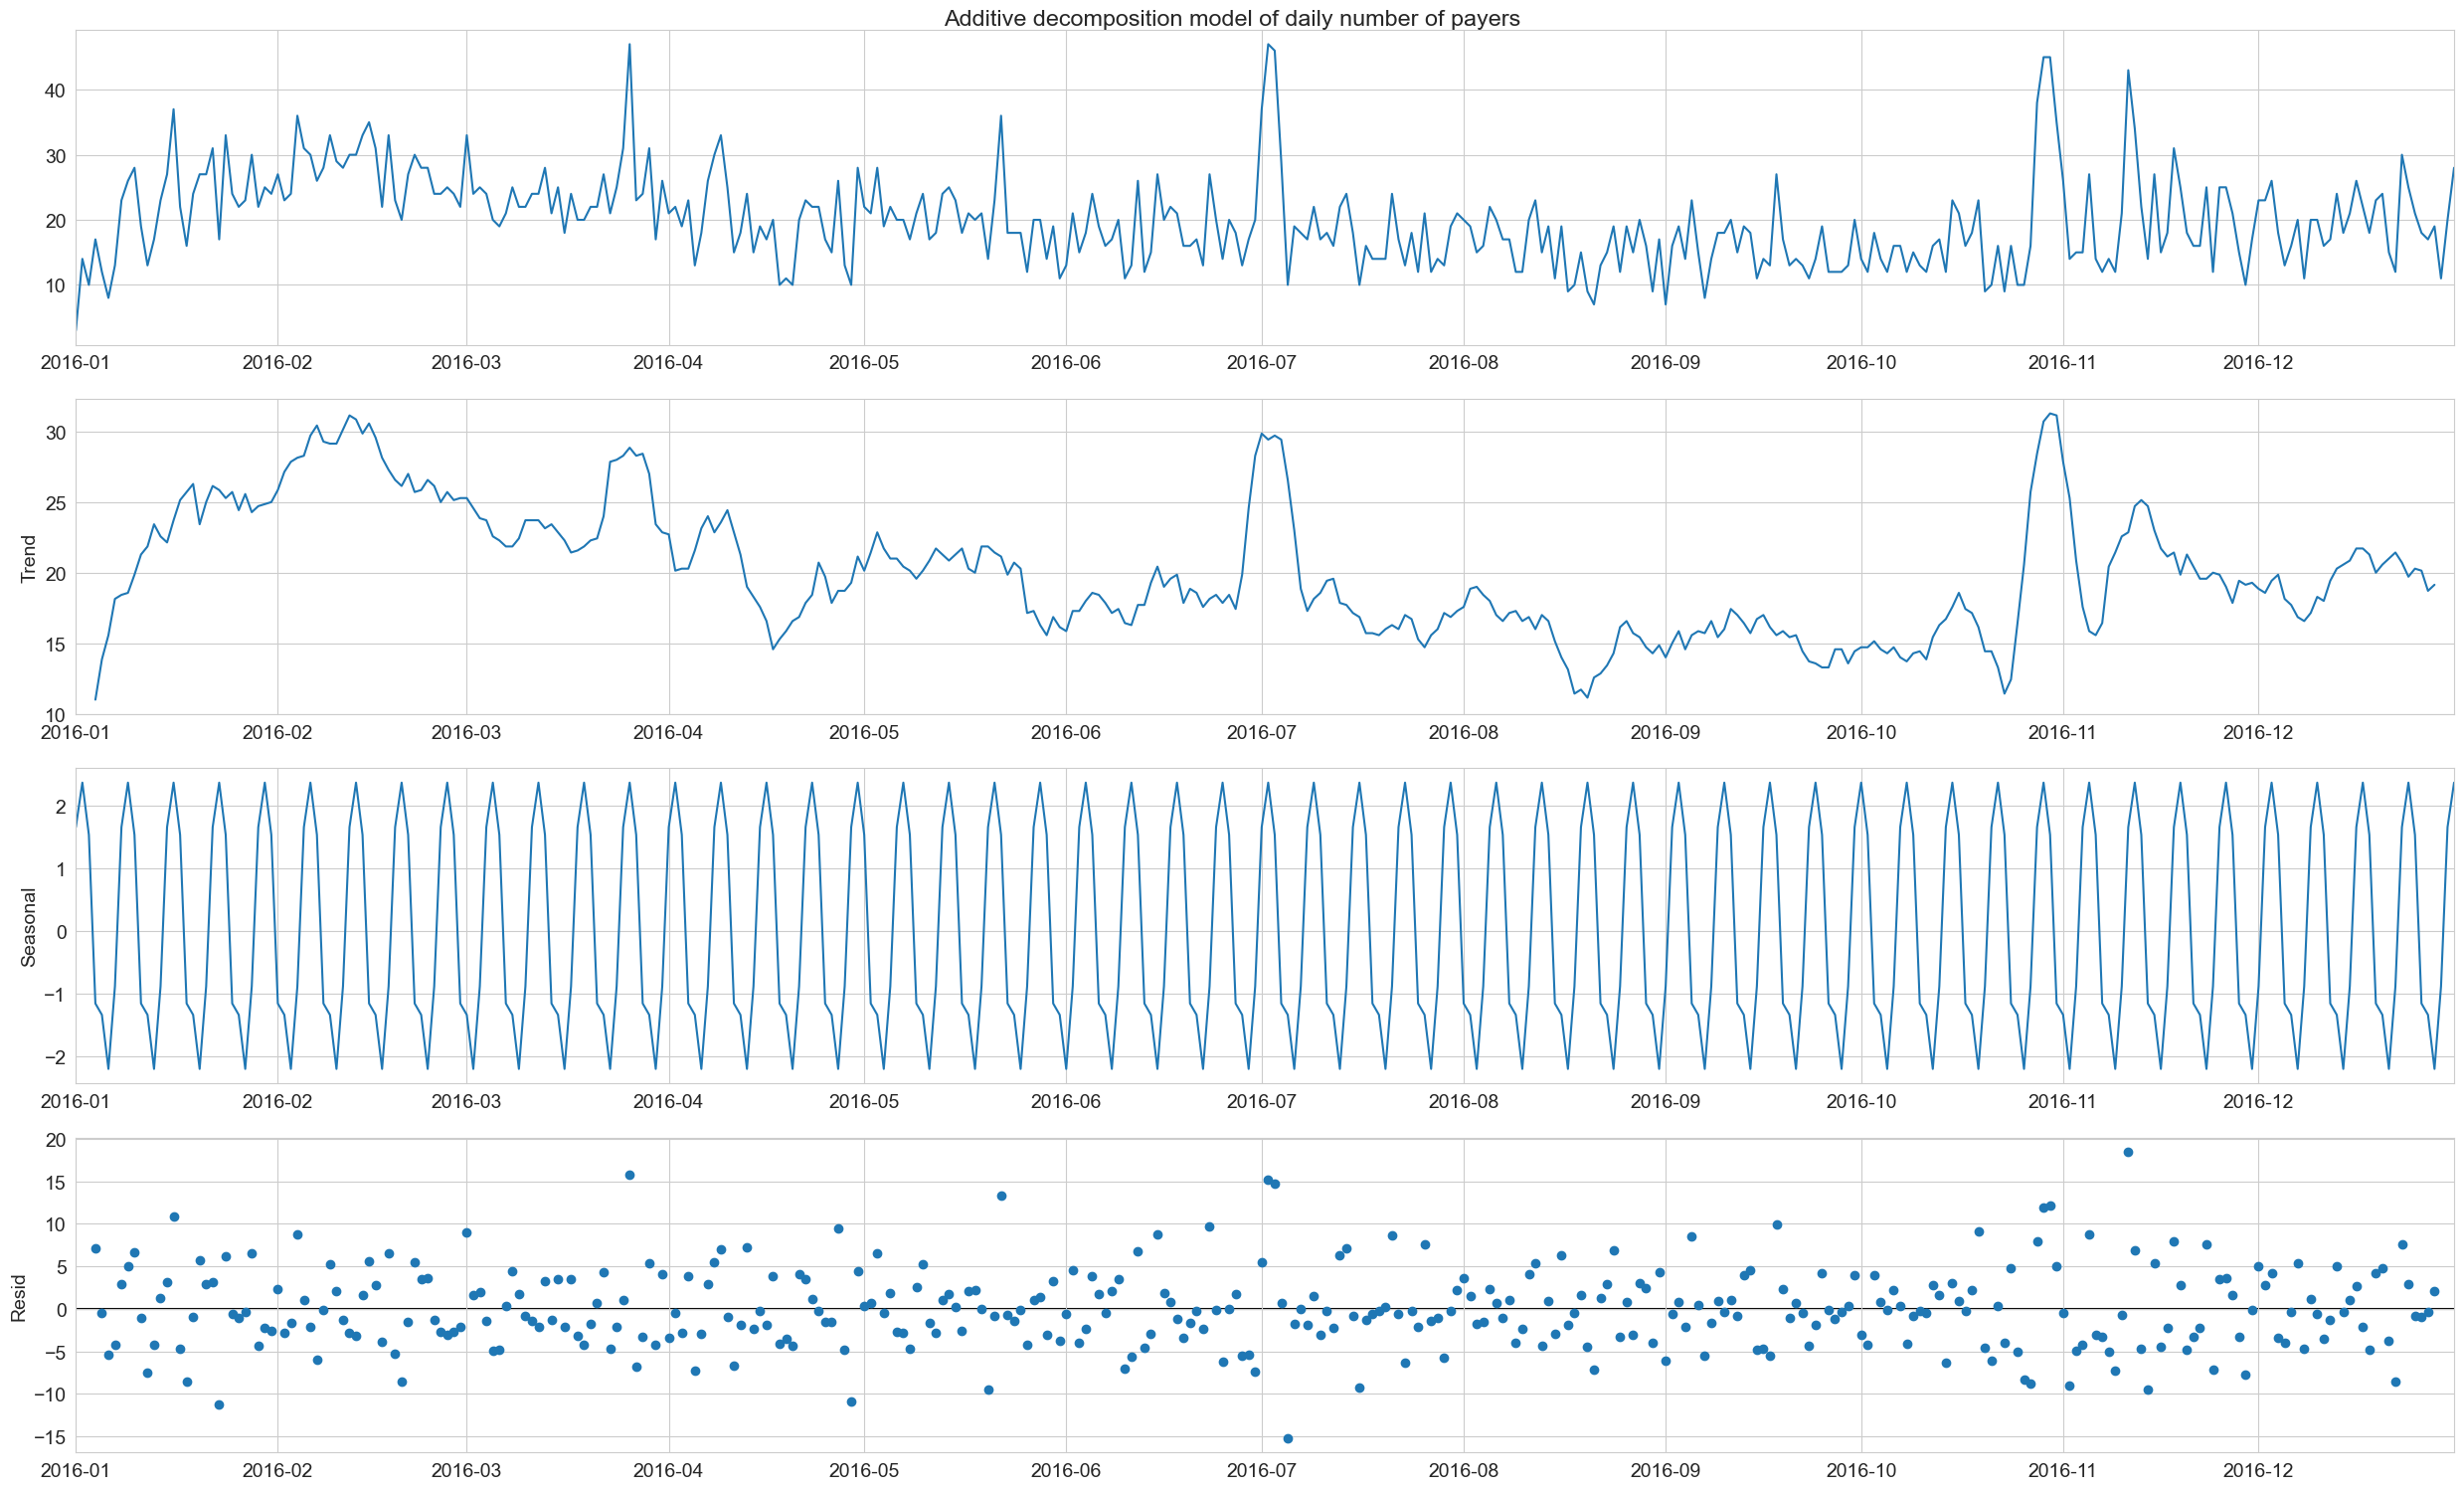

In [30]:
decomposition3 = sm.tsa.seasonal_decompose(payers, model='additive')
fig = decomposition3.plot()
fig.suptitle('Additive decomposition model of daily number of payers', x=0.5, y=1)
plt.show()

In [ ]:
arppu = revenue_and_active_users[['date', 'arppu']]
arppu['date'] = pd.to_datetime(arppu['date'])
arppu = arppu.set_index(['date'])
#arppu

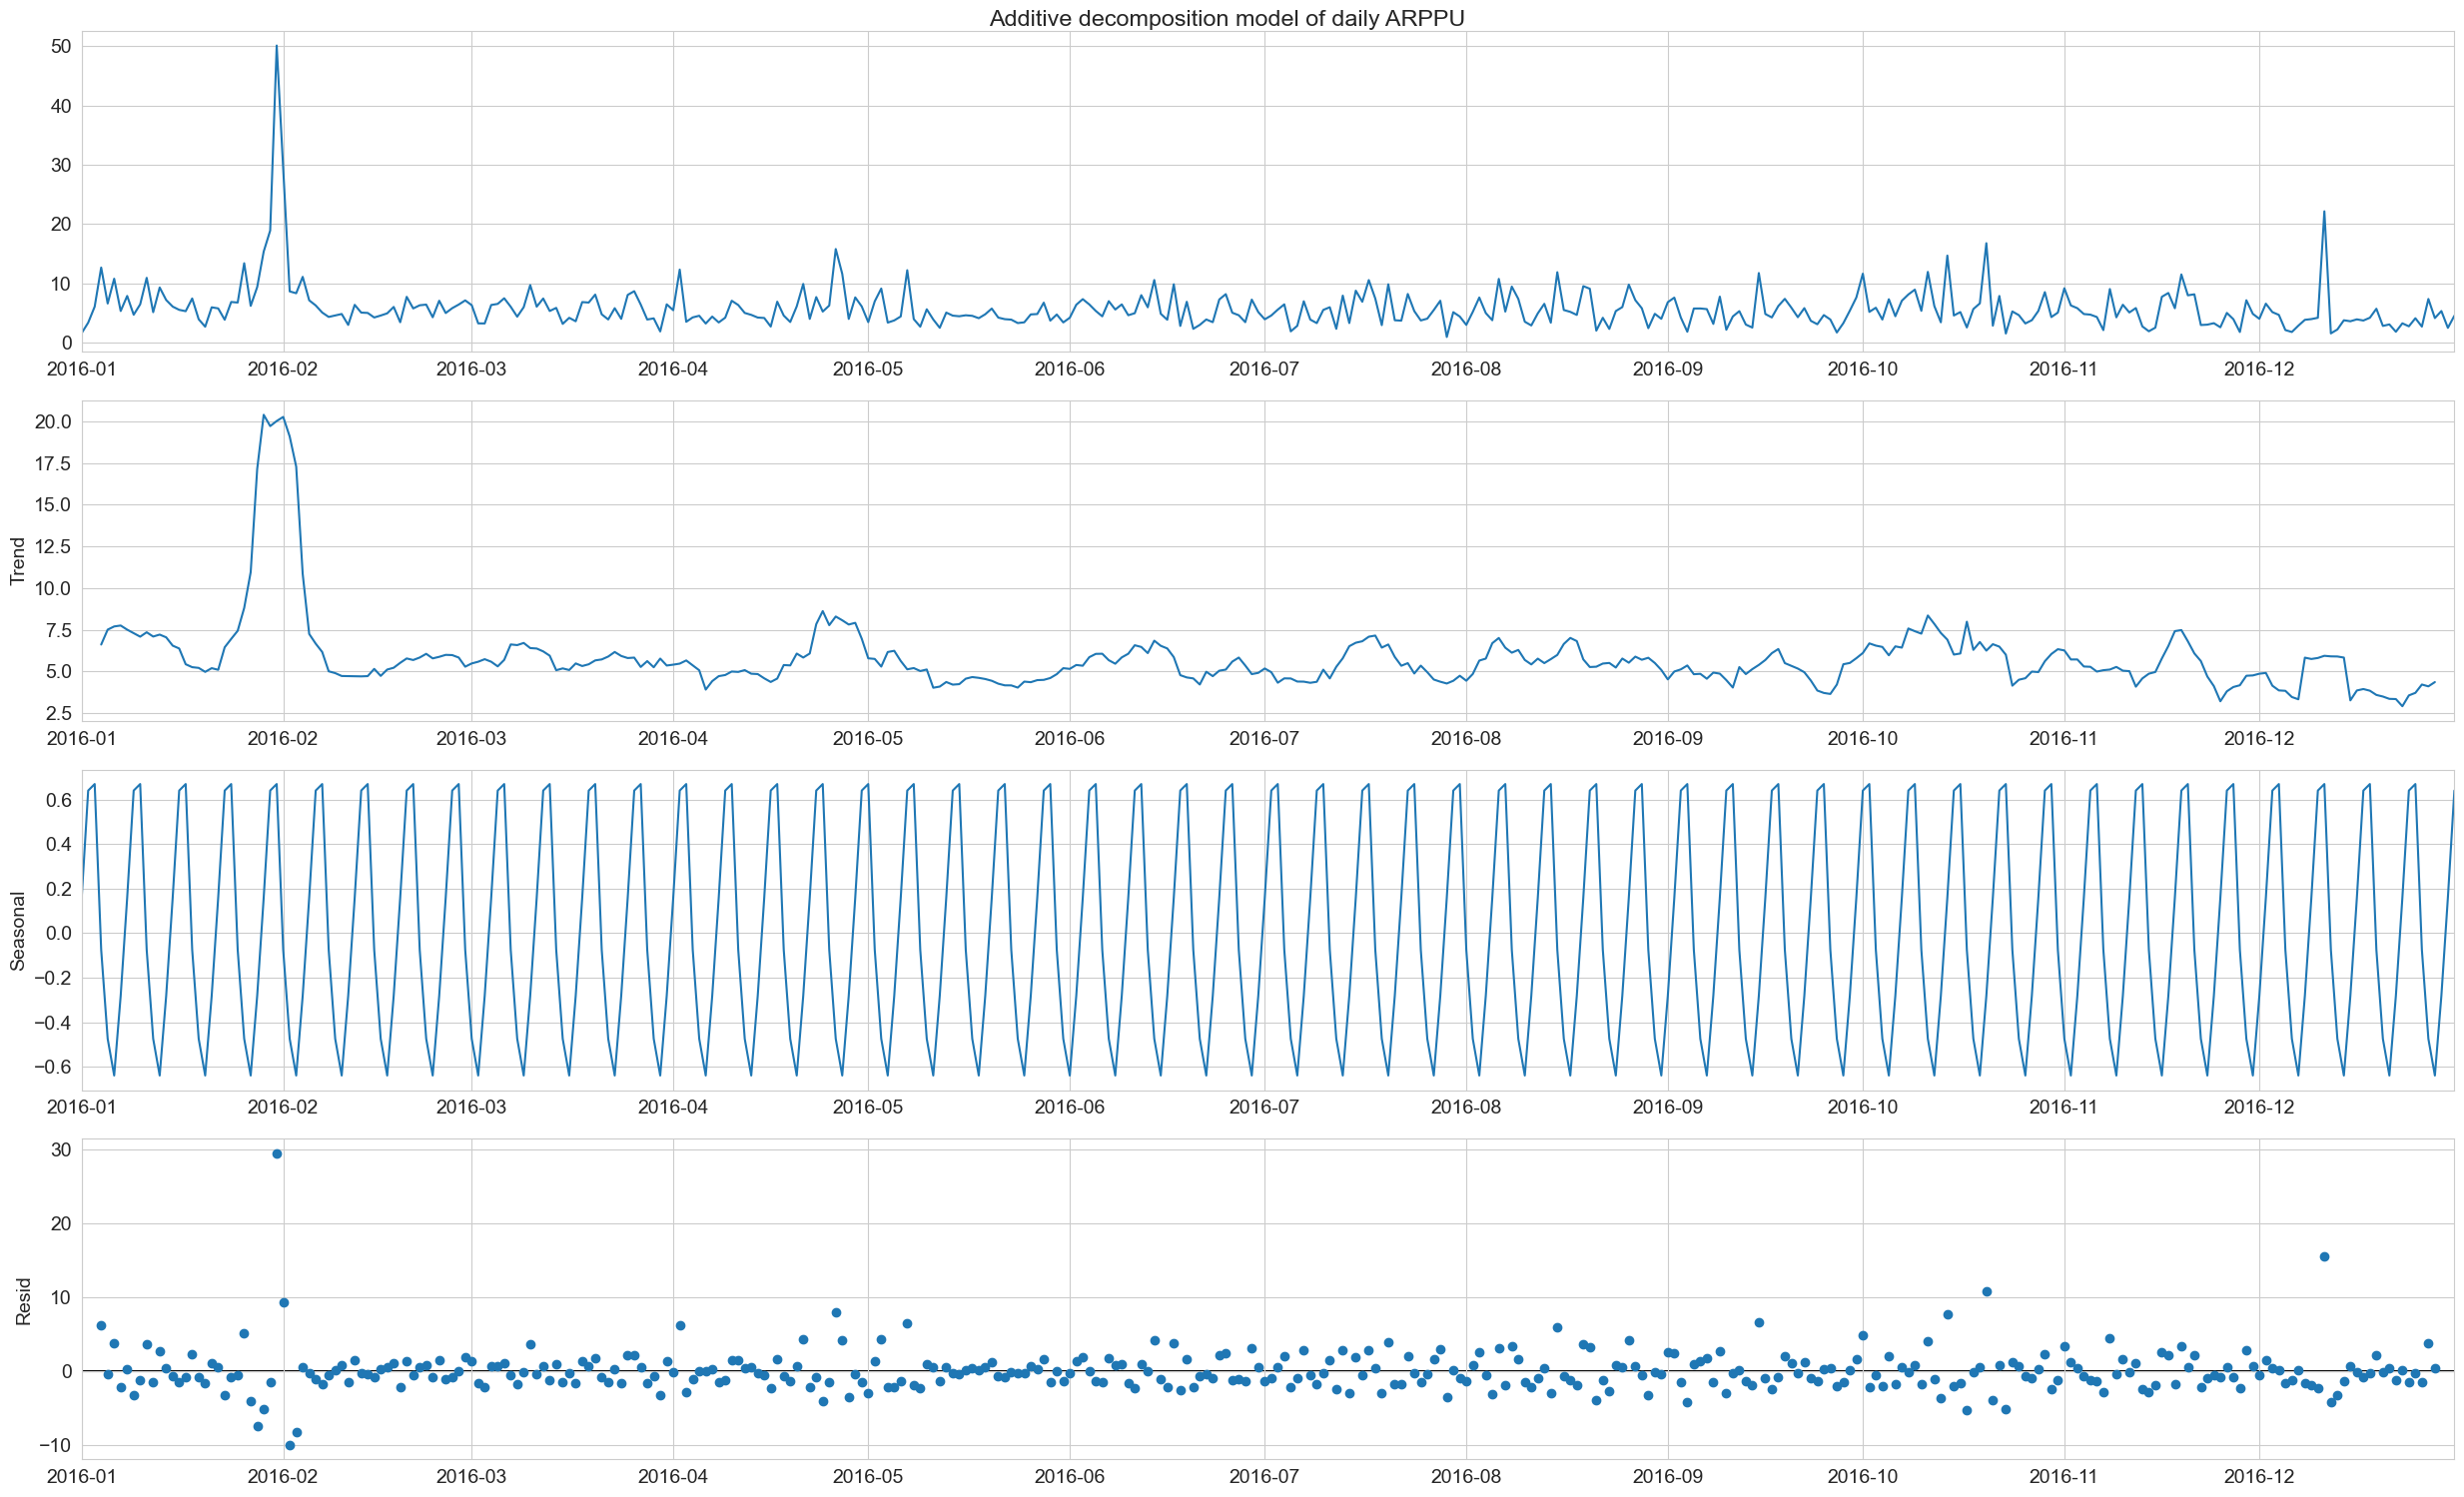

In [32]:
decomposition4 = sm.tsa.seasonal_decompose(arppu, model='additive')
fig = decomposition4.plot()
fig.suptitle('Additive decomposition model of daily ARPPU', x=0.5, y=1)
plt.show()

In [ ]:
trends = trend.rename(columns={'trend': 'total_revenue_trend'})
trends.loc[:, 'DAU_trend'] = decomposition2.trend.reset_index().trend
trends.loc[:, 'n_payers_trend'] = decomposition3.trend.reset_index().trend
trends.loc[:, 'ARPPU_trend'] = decomposition4.trend.reset_index().trend
#trends

In [34]:
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=['Trend of daily active users',
                    'Trend of number of payers daily',
                    'Trend of ARPPU daily',
                    'Trend of total revenue daily'])
figures = [
    px.line(trends, x="dates", y="DAU_trend"),
    px.line(trends, x="dates", y="n_payers_trend"),
    px.line(trends, x="dates", y="ARPPU_trend"),
    px.line(trends, x="dates", y="total_revenue_trend")
]


for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=i+1, col=1)

fig.update_layout(height=1000, width=1300)
fig.show()

In [35]:
fig.write_image('trend_graphs.png', format='png')

**Lifetime value**

In [36]:
query_ltv = '''
WITH RECURSIVE
  cnt(n_days) AS (
     SELECT 0
     UNION ALL
     SELECT n_days+1 FROM cnt
      LIMIT 366
  )

 select n_days,
        count(distinct account_id) as n_users_alive,
        sum(received_payments) as received_revenue
   from (
       select n_days,
              account_id,
              days_lifetime,
              iif(cnt.n_days = df.day_of_payment, payments, 0) as received_payments
         from cnt
         left join (
          select account_id,
             JULIANDAY(last_session_dt) - JULIANDAY(creation_dt) as days_lifetime,
             ifnull(JULIANDAY(payment_dt) - JULIANDAY(creation_dt), 0) as day_of_payment,
             creation_dt,
             last_session_dt,
             payment_dt,
             payments
        from (
           select a.account_id,
                   date(a.created_time) as creation_dt,
                   ifnull(ads.last_session, date(a.created_time)) as last_session_dt,
                   ip.payment_dt,
                   ifnull(ip.payments_usd, 0) as payments
              from account a
              left join (SELECT account_id as spa_id,
                                max(date) as last_session
                           from account_date_session
                          group by account_id) ads
                on a.account_id = ads.spa_id
              left join (select account_id as spa_key,
                                date(created_time) as payment_dt,
                                sum(iap_price_usd_cents)/100.0 as payments_usd
                           from iap_purchase
                          group by 1, 2) ip
                on a.account_id = ip.spa_key
             ) df ) df
           on cnt.n_days <= df.days_lifetime
       group by n_days,
                account_id,
                days_lifetime,
                iif(cnt.n_days = df.day_of_payment, payments, 0)
        ) agg
 GROUP by n_days
'''

In [ ]:
cumulative_revenue = pd.read_sql_query(query_ltv, sqlite_connection)
#cumulative_revenue

In [ ]:
cumulative_rev = cumulative_revenue.received_revenue.cumsum(axis=0)
#cumulative_rev

In [ ]:
n_unique_users = cumulative_revenue.iloc[0, 1]
cumulative_arpu = cumulative_rev / n_unique_users
#cumulative_arpu

In [ ]:
cumulative_revenue.loc[:, 'cumulative_arpu'] = cumulative_arpu
#cumulative_revenue

In [41]:
fig = px.line(cumulative_revenue, x="n_days", y="cumulative_arpu", title='Average lifetime revenue by days since creating an account (all users)')
fig.update_layout(width=1000)
fig.show()

In [42]:
fig.write_image('ltv.png', format='png')

In [43]:
first_week_revenue = cumulative_rev.iloc[7] / cumulative_rev.iloc[365]
print(f"{first_week_revenue:.2%} - share of LTV generated during the first week")

18.38% - share of LTV generated during the first week


In [44]:
query_ltv_jan = '''
WITH RECURSIVE
  cnt(n_days) AS (
     SELECT 0
     UNION ALL
     SELECT n_days+1 FROM cnt
      LIMIT 366
  )

 select n_days,
        sum(received_payments) as received_revenue
   from (
       select n_days,
              iif(cnt.n_days = df.day_of_payment, payments, 0) as received_payments
         from cnt
         left join (
          select account_id,
             JULIANDAY(last_session_dt) - JULIANDAY(creation_dt) as days_lifetime,
             ifnull(JULIANDAY(payment_dt) - JULIANDAY(creation_dt), 0) as day_of_payment,
             creation_dt,
             last_session_dt,
             payment_dt,
             payments
        from (
           select a.account_id,
                   date(a.created_time) as creation_dt,
                   ifnull(ads.last_session, date(a.created_time)) as last_session_dt,
                   ip.payment_dt,
                   ifnull(ip.payments_usd, 0) as payments
              from account a
              left join (SELECT account_id as spa_id,
                                max(date) as last_session
                           from account_date_session
                          group by account_id) ads
                on a.account_id = ads.spa_id
              left join (select account_id as spa_key,
                                date(created_time) as payment_dt,
                                sum(iap_price_usd_cents)/100.0 as payments_usd
                           from iap_purchase
                          group by 1, 2) ip
                on a.account_id = ip.spa_key
             where STRFTIME("%Y-%m", a.created_time) = '2016-01'
             ) df ) df
           on cnt.n_days <= df.days_lifetime
       group by n_days,
                account_id,
                iif(cnt.n_days = df.day_of_payment, payments, 0)
        ) agg
 GROUP by n_days
'''

In [ ]:
january_cohort_ltv = pd.read_sql_query(query_ltv_jan, sqlite_connection)
#january_cohort_ltv

In [ ]:
cumulative_rev_jan = january_cohort_ltv.received_revenue.cumsum(axis=0)
#cumulative_rev_jan

In [47]:
query_jan_cohort = '''
select count(account_id) as n_users
  from account
 where STRFTIME("%Y-%m", created_time) = '2016-01'
'''

In [48]:
january_cohort = pd.read_sql_query(query_jan_cohort, sqlite_connection)
january_cohort

n_users
0    20760

In [ ]:
n_jan_users = january_cohort.iloc[0, 0]
cumulative_arpu_jan = cumulative_rev_jan / n_jan_users
#cumulative_arpu_jan

In [ ]:
january_cohort_ltv.loc[:, 'cumulative_arpu'] = cumulative_arpu_jan
#january_cohort_ltv

In [51]:
fig = px.line(january_cohort_ltv, x="n_days", y="cumulative_arpu", title='Average lifetime revenue by days since creating an account (January cohort)')
fig.update_layout(width=1000)
fig.show()

In [52]:
fig.write_image('ltv_jan.png', format='png')

In [53]:
first_week_revenue = cumulative_rev_jan.iloc[7] / cumulative_rev_jan.iloc[365]
print(f"{first_week_revenue:.2%} - share of LTV generated during the first week by the users who created their accounts in January")

13.19% - share of LTV generated during the first week by the users who created their accounts in January


In [3]:
query_ltv_cohorts = '''
WITH RECURSIVE
  cnt(n_days) AS (
     SELECT 0
     UNION ALL
     SELECT n_days+1 FROM cnt
      LIMIT 366
  )

 select n_days,
        month_cohort,
        count(account_id) as n_users,
        sum(received_payments) as received_revenue
   from (
       select n_days,
              account_id,
              month_cohort,
              iif(cnt.n_days = df.day_of_payment, payments, 0) as received_payments
         from cnt
         left join (
          select account_id,
                 month_cohort,
                 JULIANDAY(last_session_dt) - JULIANDAY(creation_dt) as days_lifetime,
                 ifnull(JULIANDAY(payment_dt) - JULIANDAY(creation_dt), 0) as day_of_payment,
                 creation_dt,
                 last_session_dt,
                 payment_dt,
                 payments
        from (
           select a.account_id,
                   date(a.created_time) as creation_dt,
                   STRFTIME("%Y-%m", a.created_time) as month_cohort,
                   ifnull(ads.last_session, date(a.created_time)) as last_session_dt,
                   ip.payment_dt,
                   ifnull(ip.payments_usd, 0) as payments
              from account a
              left join (SELECT account_id as spa_id,
                                max(date) as last_session
                           from account_date_session
                          group by account_id) ads
                on a.account_id = ads.spa_id
              left join (select account_id as spa_key,
                                date(created_time) as payment_dt,
                                sum(iap_price_usd_cents)/100.0 as payments_usd
                           from iap_purchase
                          group by 1, 2) ip
                on a.account_id = ip.spa_key
             ) df ) df
           on cnt.n_days <= df.days_lifetime
       group by n_days,
                account_id,
                month_cohort,
                iif(cnt.n_days = df.day_of_payment, payments, 0)
        ) agg
 GROUP by n_days,
          month_cohort
'''

In [ ]:
cohorts_ltv = pd.read_sql_query(query_ltv_cohorts, sqlite_connection)
#cohorts_ltv

In [ ]:
cohorts_count = cohorts_ltv.iloc[0:12, 1:3]
cohorts_ltv = cohorts_ltv.merge(cohorts_count, on='month_cohort', suffixes=('','_total'), how='left')
#cohorts_ltv

In [ ]:
grouped_cohorts = pd.pivot_table(cohorts_ltv, index=['month_cohort', 'n_days', 'n_users_total'], values='received_revenue').reset_index()
grouped_cohorts.loc[:, 'cumulative_revenue'] = grouped_cohorts.groupby(['month_cohort'])[['received_revenue']].cumsum()
grouped_cohorts.loc[:, 'cumulative_arpu'] = grouped_cohorts['cumulative_revenue'] / grouped_cohorts['n_users_total']
#grouped_cohorts

In [40]:
fig = px.line(grouped_cohorts, x="n_days", y="cumulative_arpu",
              title='Average lifetime revenue by days since creating an account (monthly cohorts)',
              color='month_cohort')
fig.update_layout(width=1200, height=600)
fig.show()

In [41]:
fig.write_image('ltv_cohorts.png', format='png')

In [42]:
query_lft_monthly = '''
       select registration_month,
              count(distinct account_id) as n_users_registered,
              avg(days_lifetime) as mean_lifetime,
              max(days_lifetime) as max_lifetime,
              sum(total_payments) as total_payments
         from (
          select account_id,
           		 registration_month,
                 JULIANDAY(last_session_dt) - JULIANDAY(creation_dt) as days_lifetime,
                 total_payments
        from (
           select a.account_id,
                  STRFTIME("%Y-%m", a.created_time) as registration_month,
                   date(a.created_time) as creation_dt,
                   ifnull(ads.last_session, date(a.created_time)) as last_session_dt,
                   ifnull(ip.payments_usd, 0) as total_payments
              from account a
              left join (SELECT account_id as spa_id,
                                max(date) as last_session
                           from account_date_session
                          group by account_id) ads
                on a.account_id = ads.spa_id
              left join (select account_id as spa_key,
                                sum(iap_price_usd_cents)/100.0 as payments_usd
                           from iap_purchase
                          group by 1) ip
                on a.account_id = ip.spa_key
             ) df ) dt
       group by registration_month

'''

In [43]:
lft_monthly = pd.read_sql_query(query_lft_monthly, sqlite_connection)
lft_monthly

registration_month  n_users_registered  mean_lifetime  max_lifetime  \
0             2016-01               20760      45.244220         365.0   
1             2016-02               13776      36.392059         334.0   
2             2016-03               11478      34.495818         305.0   
3             2016-04                9232      31.901755         274.0   
4             2016-05                8433      29.201945         244.0   
5             2016-06                7953      25.233371         213.0   
6             2016-07                8598      21.759363         183.0   
7             2016-08                7809      18.657447         152.0   
8             2016-09                6237      16.821869         121.0   
9             2016-10                6331      12.966514          91.0   
10            2016-11                5579       9.508873          60.0   
11            2016-12                6606       3.881169          30.0   

    total_payments  
0         20116.32  
1          5520.65  
2          1985.29  
3          2484.05  
4          3550.87  
5          1562.95  
6          3328.06  
7          1110.42  
8           921.15  
9           726.15  
10          729.74  
11          482.97

In [44]:
fig = px.bar(lft_monthly, x="registration_month", y="n_users_registered", title='Number of created accounts per month')
fig.update_layout(width=1000)
fig.show()

In [45]:
fig.write_image('new_accounts_monthly.png', format='png')

In [47]:
if sqlite_connection:
    sqlite_connection.close()
    print("The SQLite connection is closed")

The SQLite connection is closed
